<a href="https://colab.research.google.com/github/Armanskij/Projeto-Eleicoes-MogidasCruzes-2024/blob/main/Projeto_Eleicoes_Mogidascruzes_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="20">Análise dos Candidatos Municipais de Mogi das Cruzes - 2024</font>





Projeto elaborado por [Douglas Rizzi](https://www.linkedin.com/in/douglas-rizzi/)

Setembro/2024

# Definição do Problema

Em meio ao crescente número de candidatos e partidos,
torna-se essencial entender o perfil daqueles que concorrem às eleições municipais, especialmente devido à sua presença mais próxima e atuante no cotidiano da população.

Com a diversidade de características entre os candidatos, a escolha torna-se cada vez mais complexa. No entanto, ao analisar o perfil geral dos concorrentes, é possível identificar características predominantes em vários aspectos. Este projeto tem como objetivo descrever o perfil médio dos candidatos de Mogi das Cruzes para as eleições municipais de 2024, fornecendo informações que possam orientar escolhas de forma mais informada.

Além das propostas e projetos de governo, atributos como idade, gênero, cor/raça, escolaridade e ocupação podem oferecer uma visão mais clara de como os partidos estão estruturando suas candidaturas, ajudando o eleitor a identificar o candidato que mais representa seus ideais. Vale destacar que esta análise utiliza exclusivamente dados fornecidos pelo TSE, servindo como um ponto de partida para a escolha dos candidatos, sem substituir a necessidade de uma pesquisa mais aprofundada sobre as propostas e posicionamentos de cada um. O dever de todo cidadão é garantir que as propostas de seus candidatos atendam às suas expectativas e necessidades.

Ao final deste projeto, esperamos identificar padrões entre os candidatos dos diversos partidos, compreendendo melhor o perfil demográfico predominante, como idade, gênero, cor/raça, além de aspectos educacionais e ocupacionais. Com essa análise, buscamos encontrar insights valiosos sobre o histórico acadêmico e profissional dos candidatos, fornecendo uma visão mais ampla de quem são os representantes que concorrem às eleições municipais de Mogi das Cruzes em 2024. Esses dados podem ajudar a traçar um panorama mais preciso sobre como os partidos estão organizando suas candidaturas, permitindo aos eleitores fazer escolhas mais informadas e alinhadas com seus próprios valores e expectativas.

## Bibliotecas utilizadas

In [1]:
import os
import zipfile

import numpy as np
import pandas as pd
import requests
import sqlite3
from sqlalchemy import create_engine, MetaData

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from IPython.display import display, HTML
import pprint
import warnings


In [2]:
warnings.filterwarnings('ignore')

## Sobre a cidade de Mogi das Cruzes

Mogi das Cruzes é um município localizado na região metropolitana de São Paulo, no Brasil, a cerca de 50 km da capital paulista. Fundada em 1560, a cidade é conhecida por sua história rica e cultura diversificada, além de sua economia dinâmica, que abrange desde a agricultura, especialmente o cultivo de hortaliças e flores, até setores industriais e comerciais.

Com uma população de aproximadamente 450 mil habitantes, Mogi das Cruzes destaca-se por sua infraestrutura urbana, boas opções de lazer e educação, além de importantes áreas de preservação ambiental, como a Serra do Itapeti e o Parque Natural Municipal Francisco Affonso de Mello. A cidade é um polo de desenvolvimento no Alto Tietê e possui uma crescente influência no cenário econômico e político da região.

Alguns dados interessantes sobre a cidade:
- **Fundação:** 1° de setembro de 1611 (413 anos)
- **Área Total:** 712,541 km² (12° do Estado)
- **Distância da capital:** 60km
- **População Total:** 449.955 hab.
- **IDH:** 0,783 (*alto*, 60° BR)
- **PIP:** R$ 15.386.499,31
- **Prefeito:** Caio Cesar Machado da Cunha (PODE, 2021-2024)

# Coleta dos dados

A base de dados utilizada neste projeto foi extraída do site do [Tribunal Superior Eleitoral (TSE)](https://dados.gov.br/dados/conjuntos-dados/candidatos-2024) em setembro de 2024. Ela contém informações detalhadas de todos os candidatos que concorrem às Eleições Municipais de 2024 em todo o território nacional. Essa base inclui dados como nome, partido, gênero, idade, cor/raça, escolaridade e ocupação dos candidatos. Embora o TSE também disponibilize outras informações, como bens dos candidatos, coligações e motivos de cassação, este projeto focará exclusivamente nos dados demográficos e gerais dos candidatos, conforme definido pelo escopo. A análise de outras variáveis poderá ser incluída em projetos futuros, proporcionando uma visão ainda mais aprofundada do perfil dos candidatos.

In [3]:
# confi do magic command %sql
!pip install ipython-sql -q
!pip install sqlalchemy -q
%load_ext sql
%sql sqlite:///:memory:

In [4]:
URL ='https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2024.zip'

# caminho para salvar o arquivo
file_path = '/content/sample_data/projeto-eleicoes'
response = requests.get(URL)

if response.status_code == 200:
    with open(file_path,"wb") as file:
        file.write(response.content)
    print(f"Arquivo baixado e salvo em {file_path}.")
else:
    print(
        f"Falha ao baixar o arquivo. Código de status {response.status_code}.")

Arquivo baixado e salvo em /content/sample_data/projeto-eleicoes.


In [5]:
# o arquivo esta compactado em .zip vamos descompacta-lo
extract_to = 'projeto-eleicoes'
#arquivos de interesse para extrair (estado de SP)
files_to_extract = ['leiame.pdf','consulta_cand_2024_SP.csv']

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    all_files = zip_ref.namelist()

    for file in files_to_extract:
        if file in all_files:
            zip_ref.extract(file, extract_to)
    print(f'Descompactado para a pasta: {extract_to}')

Descompactado para a pasta: projeto-eleicoes


In [6]:
csv_file_path = '/content/projeto-eleicoes/consulta_cand_2024_SP.csv'
df_v1 = pd.read_csv(csv_file_path, encoding='latin1', sep=";")

Vemos que nosso banco de dados bruto contêm diversas colunas e um número bem grande de entradas (aproximadamente 80 mil)

In [7]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78289 entries, 0 to 78288
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   DT_GERACAO                     78289 non-null  object
 1   HH_GERACAO                     78289 non-null  object
 2   ANO_ELEICAO                    78289 non-null  int64 
 3   CD_TIPO_ELEICAO                78289 non-null  int64 
 4   NM_TIPO_ELEICAO                78289 non-null  object
 5   NR_TURNO                       78289 non-null  int64 
 6   CD_ELEICAO                     78289 non-null  int64 
 7   DS_ELEICAO                     78289 non-null  object
 8   DT_ELEICAO                     78289 non-null  object
 9   TP_ABRANGENCIA_ELEICAO         78289 non-null  object
 10  SG_UF                          78289 non-null  object
 11  SG_UE                          78289 non-null  int64 
 12  NM_UE                          78289 non-null  object
 13  C

In [8]:
df_v1.head(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA_ELEICAO,...,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_COR_RACA,DS_COR_RACA,CD_OCUPACAO,DS_OCUPACAO,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO
0,01/10/2024,16:31:49,2024,2,ELEIÇÃO ORDINÁRIA,1,619,Eleições Municipais 2024,06/10/2024,MUNICIPAL,...,8,SUPERIOR COMPLETO,9,DIVORCIADO(A),1,BRANCA,131,ADVOGADO,-1,#NULO#
1,01/10/2024,16:31:49,2024,2,ELEIÇÃO ORDINÁRIA,1,619,Eleições Municipais 2024,06/10/2024,MUNICIPAL,...,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),3,PARDA,109,AGENTE DE SAÚDE E SANITARISTA,-1,#NULO#
2,01/10/2024,16:31:49,2024,2,ELEIÇÃO ORDINÁRIA,1,619,Eleições Municipais 2024,06/10/2024,MUNICIPAL,...,4,ENSINO FUNDAMENTAL COMPLETO,7,SEPARADO(A) JUDICIALMENTE,2,PRETA,402,"VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIA...",-1,#NULO#


# Tratamento dos dados



O uso do [SQLAlchemy](https://www.sqlalchemy.org/) neste projeto foi escolhido por sua capacidade de abstrair consultas SQL complexas de maneira eficiente, garantindo a segurança contra injeções de SQL e facilitando a manipulação de grandes volumes de dados através de seu mapeamento objeto-relacional ([ORM](https://blog.cubos.academy/orm-object-relational-mapper/)). Ele permite integrar facilmente diferentes bancos de dados, além de otimizar o desempenho das operações e tornar o código mais legível e escalável, o que é crucial para lidar com as diversas análises realizadas sobre o perfil dos candidatos das eleições municipais de 2024.

In [9]:
engine = create_engine('sqlite:///eleicoes_sp.db', echo=False)

# Carregar a extensão SQL e conectar ao banco de dados SQLite no arquivo
%load_ext sql
%sql sqlite:///eleicoes_sp.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [10]:
# convertendo noso arquivo para um .bd sql
df_v1.to_sql('tabela_csv', con=engine, index=False, if_exists='replace')

78289

Para caracterizar adequadamente os candidatos e identificar padrões significativos entre eles, selecionei dentre um conjunto de mais de 40 variáveis relevantes que possibilitam uma análise aprofundada. Essas variáveis foram escolhidas por sua capacidade de oferecer uma visão abrangente sobre o perfil dos candidatos, permitindo a separação de conjuntos relacionados e a geração de insights valiosos. As variáveis selecionadas incluem:
- DS_CARGO : Descriçao do cargo do candidato (vereador, vice-prefeito e prefeito)
- NM_CANDIDATO: Nome completo do candidato
- NR_PARTIDO: Número do partido do candidato
- SG_PARTIDO: Sigla do partido do candidato
- SG_UF_NASCIMENTO: Estado de nascimento do candidato
- CD_GENERO: Código do gênero do candidato (2:Masculino, 4:Feminino)
- CD_GRAU_INSTRUCAO: Código do grau de instrução (escolaridade) do candidato, podendo assumir os seguintes valores:
  - 1: Analfabeto;
  - 2: Lê e escreve;
  - 3: Ensino fundamental incompleto;
  - 4: Ensino fundamental completo;
  - 5: Ensino médio incompleto;
  - 6: Ensino médio completo;
  - 7: Superior incompleto; e
  - 8: Superior completo.
- CD_ESTADO_CIVIL: Código do estado civil do candidato.
- DT_NASCIMENTO: Data de nascimento do candidato.
- CD_COR_RACA: Código da cor/raça do candidato, podendo assumir os seguintes valores:
  - 01: Branca;
  - 02: Preta;
  - 03: Parda;
  - 04: Amarela;
  - 05: Indígena; e
  - 06: Não Informado.
- CD_OCUPACAO: Código da ocupação do candidato.
- DS_OCUPACAO: Descrição da ocupação do candidato.



In [11]:
%%sql
--- criando uma tabela sql apenas com os campos de interesse
CREATE TABLE IF NOT EXISTS candidatos_mogi AS
SELECT
DS_CARGO,
NM_CANDIDATO,
NR_PARTIDO,
SG_PARTIDO,
NM_PARTIDO,
SG_UF_NASCIMENTO,
DT_NASCIMENTO,
CD_GENERO,
CD_GRAU_INSTRUCAO,
CD_ESTADO_CIVIL,
CD_COR_RACA,
CD_OCUPACAO,
DS_OCUPACAO
FROM tabela_csv
WHERE NM_UE = 'MOGI DAS CRUZES'
--- apenas da cidade de Mogi das Cruzes/SP

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

In [12]:
%%sql
select * from candidatos_mogi LIMIT 5

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


DS_CARGO,NM_CANDIDATO,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,SG_UF_NASCIMENTO,DT_NASCIMENTO,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,DS_OCUPACAO
VEREADOR,LEANDRO MARCONDES TEIXEIRA,40,PSB,PARTIDO SOCIALISTA BRASILEIRO,SP,21/07/2000,2,8,1,1,298,SERVIDOR PÚBLICO MUNICIPAL
VEREADOR,MARCOS ALBERTO CAMPOS NETO,77,SOLIDARIEDADE,SOLIDARIEDADE,SP,08/01/1973,2,6,3,2,254,VIGILANTE
VEREADOR,LEONARDO LEITE GONCALVES,44,UNIÃO,UNIÃO BRASIL,SP,26/03/1999,2,8,1,1,172,PUBLICITÁRIO
VEREADOR,PAULO HENRIQUE APARECIDO CASON,50,PSOL,PARTIDO SOCIALISMO E LIBERDADE,SP,13/07/1972,2,8,3,1,298,SERVIDOR PÚBLICO MUNICIPAL
VEREADOR,ROSENILDA FRANCELINA DA SILVA,15,MDB,MOVIMENTO DEMOCRÁTICO BRASILEIRO,PR,15/09/1978,4,8,1,2,134,ASSISTENTE SOCIAL


In [13]:
%%sql
--- observando o shape da tabela criada
PRAGMA table_info(candidatos_mogi)

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


cid,name,type,notnull,dflt_value,pk
0,DS_CARGO,TEXT,0,None,0
1,NM_CANDIDATO,TEXT,0,None,0
2,NR_PARTIDO,INT,0,None,0
3,SG_PARTIDO,TEXT,0,None,0
4,NM_PARTIDO,TEXT,0,None,0
5,SG_UF_NASCIMENTO,TEXT,0,None,0
6,DT_NASCIMENTO,TEXT,0,None,0
7,CD_GENERO,INT,0,None,0
8,CD_GRAU_INSTRUCAO,INT,0,None,0
9,CD_ESTADO_CIVIL,INT,0,None,0


Nota-se que os tipos categóricos estão no formato 'TEXT' e os númericos estão como 'INT', porém no decorrer das consultas SQL vamos converte-los para 'FLOAT' pois as agregações pedem esse tipo de dado para funcionarem melhor.

In [14]:
# lendo o aruivo com o pandas para
df_candidatos_mogi = pd.read_sql_query('SELECT * FROM candidatos_mogi', engine)
print(f'O DataFrame base que usaremos nesse projeto é composto de \
{df_candidatos_mogi.shape[0]} linhas e {df_candidatos_mogi.shape[1]} colunas')

O DataFrame base que usaremos nesse projeto é composto de 397 linhas e 13 colunas


# Analise Descritiva dos Dados


Para a realizar a análise desses dados vou separa-los em três perfis de analise devido a natureza e relação entre as variáveis:
- 1. Perfil Demográfico: Nele vamos análisar as caracteristicas demográficas dos candidatos como gênero, cor/raça, estado de nascimento e estado civil;
- 2. Perfil Educacinal e Ocupacional: Nele vamos análisar a escolaridade e principais ocupações dos candidatos, usando variáveis como grau de instrução e ocupação;
- 3. Perfil dos Partidos: Nesse perfil de análise veremos como os são caracterizados os candidados de cada partido, como é a distribuição neles em cada partido e uma breve descrição das ancôras de cada partido.

## Perfil Demográfico

Vamos analisar quais as características demográficas mais presentes nos candidatos em geral. Para isso, utilizaremos as seguintes variáveis: CD_GENERO (gênero), CD_COR_RACA (cor/raça), SG_UF_NASCIMENTO (estado de nascimento), DT_NASCIMENTO (data de nascimento) e CD_ESTADO_CIVIL (estado civil). Com essas variáveis, tentaremos responder algumas perguntas:
- Quais são as métricas de idade?
- Qual a proporção entre homens e mulheres?
- Diversidade racial e representatividade de cada grupo em comparação com a população de Mogi das Cruzes?


**Palavras-chave**: equidade de gênero, inclusão racial, mobilidade geográfica.

### Pirâmide Etária

Vamos avaliar a idade dos candidatos, gerando algumas métricas estatísticas e um gráfico de pirâmide etária para avaliarmos tanto o gênero quanto a idade.

In [15]:
%%sql
--- criando tabela onde convertemos as datas de nascimento em idade
CREATE TABLE IF NOT EXISTS idades_canditos AS
select
   CAST((julianday('now') - julianday(
    substr(DT_NASCIMENTO, 7, 4) || '-' ||
    substr(DT_NASCIMENTO, 4, 2) || '-' ||
    substr(DT_NASCIMENTO, 1, 2))) / 365.25 AS INTEGER) AS idade
FROM candidatos_mogi

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

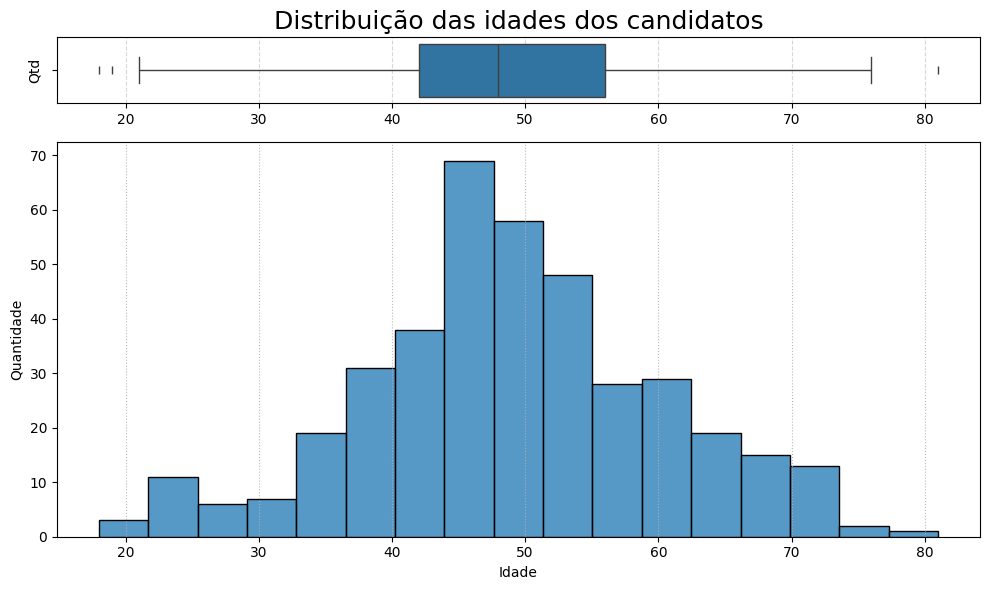

In [16]:
# convertendo sql para df  pandas
df_idades_canditos = pd.read_sql_query(
    'SELECT * FROM idades_canditos', engine)

# criando o gráfico para observar a distribuição das idades
fig, axes = plt.subplots(
    2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[1,6]})

# boxplot das idades
sns.boxplot(
    x=df_idades_canditos['idade'],
    ax=axes[0],
    linewidth=1,
    flierprops={'marker':'|'})
axes[0].set_title('Distribuição das idades dos candidatos', fontsize=18)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Qtd')


# histograma com a distribuição das idades
sns.histplot(df_idades_canditos['idade'], ax=axes[1])
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Quantidade')
axes[1].grid(axis='x', linestyle=':', alpha=0.9)

plt.tight_layout()
plt.show()

In [17]:
# métricas estatísticas das idades
df_idades_canditos.describe().round(2)

,idade
count,397.00
mean,49.01
std,11.18
min,18.00
25%,42.00
50%,48.00
75%,56.00
max,81.00


As medidas descritivas da idade dos candidatos revelam uma visão geral interessante sobre o perfil etário.

Com 397 **candidatos no total**, a **idade média** é de 48,99 anos, o que indica que a maioria dos candidatos está na faixa da meia-idade. O **desvio padrão** de 11,18 anos mostra uma dispersão moderada em torno da média, indicando uma variação considerável nas idades. O candidato **mais jovem** tem 18 anos e o **mais velho**, 81 anos.

Os quartis mostram que 25% dos candidatos têm até 42 anos, 50% até 48 anos (mediana), e 75% até 56 anos, o que reflete que a maior parte dos candidatos está na faixa entre os 40 e 60 anos.

In [18]:
%%sql
CREATE TABLE IF NOT EXISTS piramide_etaria AS
WITH idade_calculada AS(
select CD_GENERO,
   CAST((julianday('now') - julianday(
    substr(DT_NASCIMENTO, 7, 4) || '-' ||
    substr(DT_NASCIMENTO, 4, 2) || '-' ||
    substr(DT_NASCIMENTO, 1, 2))) / 365.25 AS INTEGER) AS idade
FROM candidatos_mogi
)
SELECT
    CASE
    WHEN idade BETWEEN 18 AND 24 THEN '18 a 24 anos'
    WHEN idade BETWEEN 25 AND 29 THEN '25 a 29 anos'
    WHEN idade BETWEEN 30 AND 34 THEN '30 a 34 anos'
    WHEN idade BETWEEN 35 AND 39 THEN '35 a 39 anos'
    WHEN idade BETWEEN 40 AND 44 THEN '40 a 44 anos'
    WHEN idade BETWEEN 45 AND 49 THEN '45 a 49 anos'
    WHEN idade BETWEEN 50 AND 54 THEN '50 a 54 anos'
    WHEN idade BETWEEN 55 AND 59 THEN '55 a 59 anos'
    WHEN idade BETWEEN 60 AND 64 THEN '60 a 64 anos'
    WHEN idade BETWEEN 65 AND 69 THEN '65 a 69 anos'
    WHEN idade BETWEEN 70 AND 74 THEN '70 a 74 anos'
    ELSE '75 anos ou mais'
  END AS faixa_etaria,
  SUM(CASE WHEN CD_GENERO = 2 THEN 1 ELSE 0 END) AS total_masculino,
  SUM(CASE WHEN CD_GENERO = 4 THEN 1 ELSE 0 END) AS total_feminino
FROM idade_calculada
GROUP BY faixa_etaria
ORDER BY faixa_etaria;

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

In [19]:
%%sql
SELECT * FROM piramide_etaria

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


faixa_etaria,total_masculino,total_feminino
18 a 24 anos,6,3
25 a 29 anos,6,5
30 a 34 anos,11,3
35 a 39 anos,24,12
40 a 44 anos,39,27
45 a 49 anos,54,27
50 a 54 anos,36,26
55 a 59 anos,34,16
60 a 64 anos,19,11
65 a 69 anos,18,4


In [20]:
df_piramide_etaria = pd.read_sql_query('SELECT * FROM piramide_etaria', engine)
df_piramide_etaria

,faixa_etaria,total_masculino,total_feminino
0,18 a 24 anos,6,3
1,25 a 29 anos,6,5
2,30 a 34 anos,11,3
3,35 a 39 anos,24,12
4,40 a 44 anos,39,27
5,45 a 49 anos,54,27
6,50 a 54 anos,36,26
7,55 a 59 anos,34,16
8,60 a 64 anos,19,11
9,65 a 69 anos,18,4


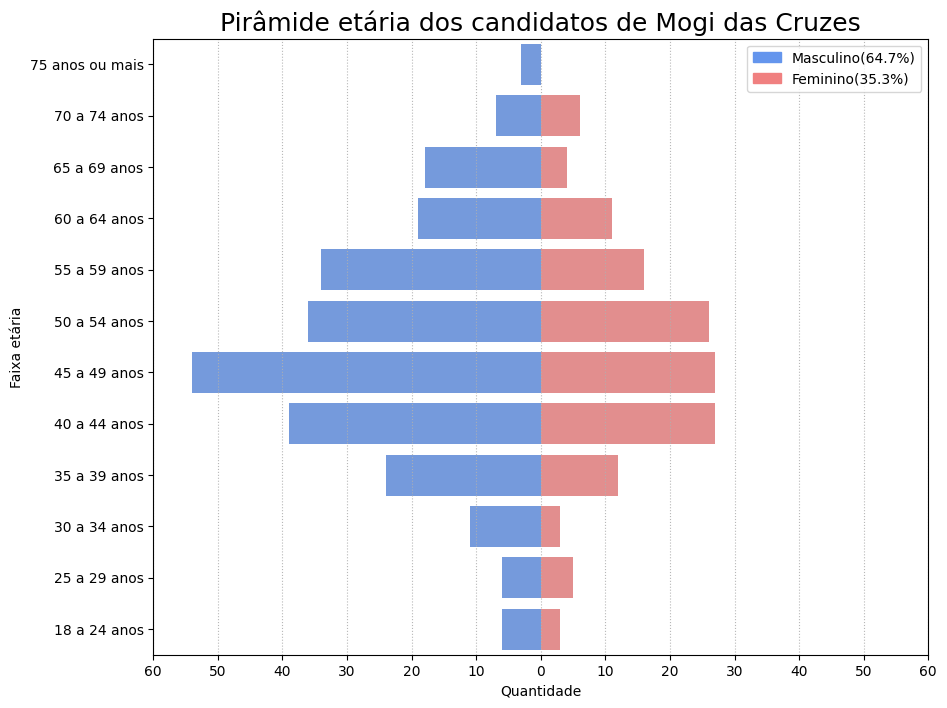

In [21]:
# adaptação para a criação do gráfico masculino invertido
df_piramide_etaria['total_masculino'] = df_piramide_etaria['total_masculino']*-1

idades=['75 anos ou mais',
        '70 a 74 anos',
        '65 a 69 anos',
        '60 a 64 anos',
        '55 a 59 anos',
        '50 a 54 anos',
        '45 a 49 anos',
        '40 a 44 anos',
        '35 a 39 anos',
        '30 a 34 anos',
        '25 a 29 anos',
        '18 a 24 anos']

plt.figure(figsize=(10,8))
# gráfico masculino
ax1 = sns.barplot(
    x='total_masculino',
    y='faixa_etaria',
    order=idades,
    data=df_piramide_etaria,
    color='cornflowerblue')

# gráfico feminino
ax2 = sns.barplot(
    x='total_feminino',
    y='faixa_etaria',
    order=idades,
    data=df_piramide_etaria,
    color='lightcoral')
plt.title('Pirâmide etária dos candidatos de Mogi das Cruzes', fontsize=18)
plt.xlabel('Quantidade')
plt.ylabel('Faixa etária')
plt.grid(False)

# invertendo sinal da legenda
plt.xticks(ticks=[-60,-50,-40,-30, -20,-10 , 0, 10, 20,30, 40, 50,60],
labels = ['60','50','40','30','20','10','0','10','20','30','40','50','60'])
plt.grid(axis='x', linestyle=':', alpha=0.9)

# legenda e calculo de % totais
total_geral = sum(
    df_piramide_etaria['total_masculino']*-1) + sum(
        df_piramide_etaria['total_feminino'])
perc_masc = round(
    (sum(df_piramide_etaria['total_masculino']*-1)/total_geral)*100,1)
perc_fem = round((sum(df_piramide_etaria['total_feminino'])/total_geral)*100,1)
masculino_patch = Patch(
    color='cornflowerblue', label=f'Masculino({perc_masc}%)')
feminino_patch = Patch(color='lightcoral', label=f'Feminino({perc_fem}%)')
plt.legend(handles=[masculino_patch, feminino_patch], loc='upper right')

A predominância masculina é clara, com **64,7%** dos candidatos sendo homens.

A representação feminina é mais significativa em faixas etárias intermediárias, especialmente entre 45 a 59 anos, mas ainda permanece menor em todas as faixas etárias em relação aos homens.

Isso levanta questões sobre a diversidade de gênero nas eleições municipais e a possível necessidade de maior equidade.

### Diversidade Racial

Sobre a diversidade racial dentre os candidatos vamos além de comparar a proporção dentre os candidatos, vamos comparar com a da população da cidade de Mogi das Cruzes.

In [22]:
%%sql
CREATE TABLE IF NOT EXISTS pizza_cor_raca AS
WITH total AS (
    SELECT COUNT(*) AS total_geral
    FROM candidatos_mogi
)
SELECT
    CASE
        WHEN CD_COR_RACA = '01' THEN 'Branca'
        WHEN CD_COR_RACA = '02' THEN 'Preta'
        WHEN CD_COR_RACA = '03' THEN 'Parda'
        WHEN CD_COR_RACA = '04' THEN 'Amarela'
        WHEN CD_COR_RACA = '05' THEN 'Indigena'
        ELSE 'Outra'
    END AS cor_raca,
    (ROUND(COUNT(*) * 100.0 / total_geral,2)) AS percentual
FROM
    candidatos_mogi,
    total
GROUP BY
    CD_COR_RACA,
    total_geral;

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

In [23]:
df_pizza_cor_raca_cand=pd.read_sql_query('SELECT * FROM pizza_cor_raca', engine)
df_pizza_cor_raca_cand

,cor_raca,percentual
0,Branca,52.64
1,Preta,11.84
2,Parda,33.25
3,Amarela,2.27


Agora temos os percentuais de cor/raça dos candidatos vamos buscar dentro do último censo do [IBGE](https://cidades.ibge.gov.br/brasil/sp/mogi-das-cruzes/pesquisa/10102/122229) qual é a distribuição da declaração de representatividade da população da cidade de Mogi das Cruzes do Censo 2022.

Para isso usaremos o serviço de [API de Dados Agregados IBGE](https://servicodados.ibge.gov.br/api/docs/agregados?versao=3#api-bq), onde solicitaremos dentro do censo de 2022 qual é o percentual geral e de cada cor/raça da população residente no município de Mogi das Cruzes/SP, o que resultara num endereço de [API](https://servicodados.ibge.gov.br/api/v3/agregados/9605/periodos/2022/variaveis/1000093?localidades=N1[all]|N6[3530607]&classificacao=86[all]) com o json dos dados solicitados.

Com ambos os dados, candidatos e população iremos construir um gráfico comparativo para ver qual será essa relação.

In [24]:
# endereço da api
api_cor_raca = 'https://servicodados.ibge.gov.br/api/v3/agregados/9605/periodos/2022/variaveis/1000093?localidades=N1[all]|N6[3530607]&classificacao=86[all]'
requisicao = requests.get(api_cor_raca)
if requisicao.status_code == 200:
    print('Requisição bem sucedida!')
else:
    print(f"Falha na requisição. Código de status: {requisicao.status_code}")
informacoes = requisicao.json()

Requisição bem sucedida!


In [25]:
# extraindo dados do json
data = []
# iterando sobre o json
for info in informacoes:
    resultados = info.get('resultados', [])

    # iterando sobre o total e cada cor/raça
    for i in range(1,6):
        if len(resultados) > i:
            series = resultados[i].get('series', [])
            if len(series) > 1:
                serie = series[1].get('serie', {})
                value = serie.get('2022')

                # Adicionar o dado extraído à lista
                data.append({
                    'cor_raca': i,
                    'percentual': value})

In [26]:
# criando o df para a população
df_pizza_cor_raca_pop = pd.DataFrame(data)
cores_raca = {
    1: 'Branca',
    2: 'Preta',
    3: 'Amarela',
    4: 'Parda',
    5: 'Indigena'
}
df_pizza_cor_raca_pop['cor_raca'] = df_pizza_cor_raca_pop[
    'cor_raca'].replace(cores_raca)
df_pizza_cor_raca_pop['percentual'] = df_pizza_cor_raca_pop[
    'percentual'].astype(float)
df_pizza_cor_raca_pop

,cor_raca,percentual
0,Branca,54.94
1,Preta,8.47
2,Amarela,3.68
3,Parda,32.79
4,Indigena,0.12


In [27]:
# comparando os df's dos candidatos e população
print(df_pizza_cor_raca_cand)
print(df_pizza_cor_raca_pop)

  cor_raca  percentual
0   Branca       52.64
1    Preta       11.84
2    Parda       33.25
3  Amarela        2.27
   cor_raca  percentual
0    Branca       54.94
1     Preta        8.47
2   Amarela        3.68
3     Parda       32.79
4  Indigena        0.12


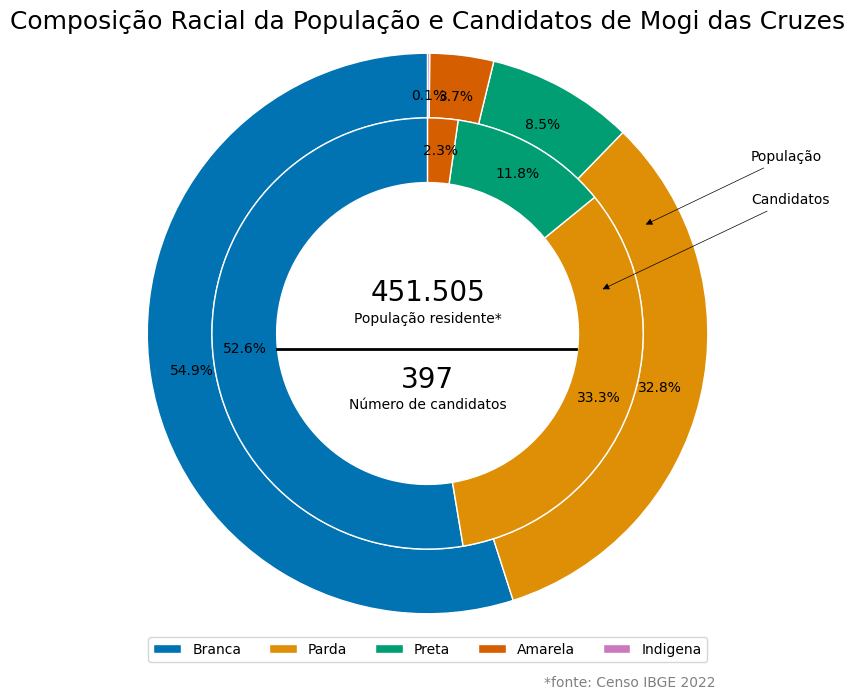

In [28]:
# organizando os df
df_cand = df_pizza_cor_raca_cand
df_pop = df_pizza_cor_raca_pop
df_pop = df_pop.sort_values('percentual', ascending=False)
df_cand = df_cand.sort_values('percentual', ascending=False)

colors = sns.color_palette("colorblind", 5) # paleta de cores
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))

# criando gráficos
ax.pie(df_pop['percentual'],
       radius=1.3,
       labels=None,
       colors=colors,
       autopct='%1.1f%%',
       startangle=90,
       wedgeprops=dict(width=0.3, edgecolor='w'),
       **{'pctdistance': 0.85})
ax.pie(df_cand['percentual'],
       radius=1.0,
       labels=None,
       colors=colors[:4],
       autopct='%1.1f%%',
       startangle=90,
       wedgeprops=dict(width=0.3, edgecolor='w'),
       **{'pctdistance': 0.85})

populacao = 451.505  # número de população residente
candidatos = 397    # número de candidatos
texto_populacao = "População residente*"
texto_candidatos = "Número de candidatos"

# criando circulo central com info's
plt.text(0, 0.15, f"{populacao:,}", fontsize=20, ha='center')
plt.text(0, 0.05, texto_populacao, fontsize=10, ha='center')
plt.plot([-0.7, 0.69], [-0.07, -0.07], color='black', lw=2)
plt.text(0, -0.25, f"{candidatos}", fontsize=20, ha='center')
plt.text(0, -0.35, texto_candidatos, fontsize=10, ha='center')

# adicionando legenda e título
plt.legend(df_pop['cor_raca'], loc="upper center",
           bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.figtext(0.8,-0.01, '*fonte: Censo IBGE 2022',
            ha='right', fontsize=10, color='gray')
plt.title('Composição Racial da População e Candidatos de Mogi das Cruzes',
          y=1.05, ha='center', fontsize=18)

# ajustes para indicações
x_candidatos = 1.5
y_candidatos = 0.8
x_populacao = 1.5
y_populacao = 0.6
plt.annotate("População", xy=(1, 0.5), xytext=(x_candidatos, y_candidatos),
                 arrowprops=dict(facecolor='black',
                                 arrowstyle='-|>', linewidth=0.5))
plt.annotate("Candidatos", xy=(0.8, 0.2), xytext=(x_populacao, y_populacao),
                 arrowprops=dict(facecolor='black',
                                 arrowstyle='-|>', linewidth=0.5))
plt.show()

Com base na distribuição de cor/raça, é possível identificar padrões entre a representatividade dos candidatos e a população. Observamos que a cor/raça branca apresenta a maior representatividade, com 54,9% da população e 52,6% dos candidatos. Na segunda posição, estão as pessoas que se autodeclaram pardas, correspondendo a 32,8% da população e 33,3% dos candidatos. Já as pessoas que se autodeclaram pretas, que representam 8,5% da população, compõem 11,8% dos candidatos. Por fim, as pessoas de cor/raça amarela representam 3,7% da população e 2,3% dos candidatos.

De modo geral, a representatividade dos candidatos reflete de maneira próxima a composição racial da população. No entanto, é interessante notar que as pessoas brancas e amarelas estão ligeiramente sub-representadas entre os candidatos em relação à sua participação na população total, enquanto as pessoas pardas e pretas estão super-representadas. Esse padrão pode sugerir um maior engajamento político entre os grupos de cor/raça parda e preta, ou possivelmente indicar uma demanda maior por políticas públicas voltadas a esses grupos.

Como sugestão para aprimorar essa análise, seria interessante observar o histórico temporal das eleições, a fim de identificar possíveis mudanças. Além disso, seria relevante verificar se houve a implementação de políticas públicas ou programas voltados para esses grupos que possam ter influenciado essa representatividade.


## Perfil Educacional e Ocupacional

Aqui vamos análisar a escolaridade e ocupação dos candidatos, utilizando as variáveis de CD_GRAU_INSTRUCAO (escolaridade) e DS_OCUPACAO (profissão). Nessa perfil de análise vamos focar em ver qual a proporção dos candidatos que estão em cada faixa de escolaridade, e quais as ocupações mais comuns dos candidatos. Algumas perguntas a serem exploradas serão:
- Qual a frequencia de cada nível de escolaridade dos candidatos?;
- Qual é a ocupação mais comum dentre os candidatos? Alguma área profissional é mais comum, tendo alguma relevância na eleição.

**Palavras-chaves**: qualificação e cargos, diversidade profissional, impacto da escolaridade.

### Grau de Escolaridade


A variável CD_GRAU_INSTRUCAO, que classifica a escolaridade dos candidatos em oito categorias, de Analfabeto a Ensino Superior Completo, permite analisar a distribuição educacional entre os diferentes grupos de candidatos. Essa análise revela o **perfil educacional** dos concorrentes e pode indicar **padrões relevantes** sobre como o nível de instrução se relaciona com a participação política.

Além disso, observar a evolução desses dados e cruzar a escolaridade com outras variáveis, como raça, gênero e partido, pode aprofundar a compreensão de como diferentes características influenciam o engajamento político. Isso oferece uma visão mais ampla sobre as possíveis conexões entre o nível de educação e as plataformas políticas defendidas pelos candidatos.

In [29]:
%%sql
CREATE TABLE IF NOT EXISTS barras_escolaridade AS
WITH total AS (
    SELECT COUNT(*) AS total_geral
    FROM candidatos_mogi
)
--- criando variável com o total de candidatos
SELECT
--- substituindo código por descrição
     CASE
        WHEN CD_GRAU_INSTRUCAO = '01' THEN 'Analfabeto'
        WHEN CD_GRAU_INSTRUCAO = '02' THEN 'Lê e escreve'
        WHEN CD_GRAU_INSTRUCAO = '03' THEN 'Ensino fundamental incompleto'
        WHEN CD_GRAU_INSTRUCAO = '04' THEN 'Ensino fundamental completo'
        WHEN CD_GRAU_INSTRUCAO = '05' THEN 'Ensino médio incompleto'
        WHEN CD_GRAU_INSTRUCAO = '06' THEN 'Ensino médio completo'
        WHEN CD_GRAU_INSTRUCAO = '07' THEN 'Superior incompleto'
        WHEN CD_GRAU_INSTRUCAO = '08' THEN 'Superior completo'
        ELSE 'Outra'
    END AS Escolaridade,
--- calculando porcentagem, convertendo int em float e arredondando resultados
    ROUND(COUNT(*) * 100.0 / (SELECT total_geral FROM total), 4) AS Total,
    ROUND(COUNT(CASE WHEN CD_GENERO = 2 THEN 1 END) * 100.0 /
        (SELECT COUNT(*) FROM candidatos_mogi WHERE CD_GENERO = 2), 4)
        AS Masculino,
    ROUND(COUNT(CASE WHEN CD_GENERO = 4 THEN 1 END) * 100.0 /
        (SELECT COUNT(*) FROM candidatos_mogi WHERE CD_GENERO = 4), 4)
        AS Feminino,
    ROUND(CAST(SUM(CASE WHEN CD_COR_RACA = 1 THEN 1 ELSE 0 END) * 100.0 /
         (SELECT COUNT(*) FROM candidatos_mogi WHERE CD_COR_RACA = 1)
         AS DECIMAL(10, 4)),4)  AS Branca,
    ROUND(CAST(SUM(CASE WHEN CD_COR_RACA = 2 THEN 1 ELSE 0 END) * 100.0 /
         (SELECT COUNT(*) FROM candidatos_mogi WHERE CD_COR_RACA = 2)
         AS DECIMAL(10, 4)),4)  AS Preta,
    ROUND(CAST(SUM(CASE WHEN CD_COR_RACA = 3 THEN 1 ELSE 0 END) * 100.0 /
         (SELECT COUNT(*) FROM candidatos_mogi WHERE CD_COR_RACA = 3)
         AS DECIMAL(10, 4)),4) AS Parda,
    ROUND(CAST(SUM(CASE WHEN CD_COR_RACA = 4 THEN 1 ELSE 0 END) * 100.0 /
         (SELECT COUNT(*) FROM candidatos_mogi WHERE CD_COR_RACA = 4)
         AS DECIMAL(10, 4)),4)  AS Amarela
FROM
    candidatos_mogi
GROUP BY
    CD_GRAU_INSTRUCAO
ORDER BY
    CD_GRAU_INSTRUCAO;

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

In [30]:
df_barras_escolaridade = pd.read_sql_query(
    'SELECT * FROM barras_escolaridade', engine)
df_barras_escolaridade

,Escolaridade,Total,Masculino,Feminino,Branca,Preta,Parda,Amarela
0,Lê e escreve,1.2594,1.5564,0.7143,1.9139,0.0000,0.7576,0.0000
1,Ensino fundamental incompleto,2.2670,3.1128,0.7143,0.9569,2.1277,4.5455,0.0000
2,Ensino fundamental completo,3.2746,3.5019,2.8571,2.8708,6.3830,3.0303,0.0000
3,Ensino médio incompleto,2.7708,1.9455,4.2857,2.8708,4.2553,1.5152,11.1111
4,Ensino médio completo,34.7607,36.9650,30.7143,30.6220,44.6809,39.3939,11.1111
5,Superior incompleto,7.8086,7.0039,9.2857,5.7416,12.7660,9.8485,0.0000
6,Superior completo,47.8589,45.9144,51.4286,55.0239,29.7872,40.9091,77.7778


Vemos que existem muitas categorias com números pouco representativos e que irão dificultar o entendimento do gráfico, por esse motivo irei unir as escolaridades Lê e escreve, Ensino fundamental incompleto, Ensino fundamental completo e ensino médio incompleto em uma só categoria chamada 'Ensino médio incompleto ou inferior'

In [31]:
rows_to_merge = df_barras_escolaridade.loc[0:3] # quatro categorias
new_row = rows_to_merge.sum()
df_barras_escolaridade = df_barras_escolaridade.drop([0,1,2,3])
new_row['Escolaridade'] = 'Ensino médio incompleto ou inferior'
new_row_df =pd.DataFrame([new_row])
df_barras_escolaridade = pd.concat([
    new_row_df, df_barras_escolaridade], ignore_index=True)
df_barras_escolaridade

,Escolaridade,Total,Masculino,Feminino,Branca,Preta,Parda,Amarela
0,Ensino médio incompleto ou inferior,9.5718,10.1166,8.5714,8.6124,12.7660,9.8486,11.1111
1,Ensino médio completo,34.7607,36.9650,30.7143,30.6220,44.6809,39.3939,11.1111
2,Superior incompleto,7.8086,7.0039,9.2857,5.7416,12.7660,9.8485,0.0000
3,Superior completo,47.8589,45.9144,51.4286,55.0239,29.7872,40.9091,77.7778


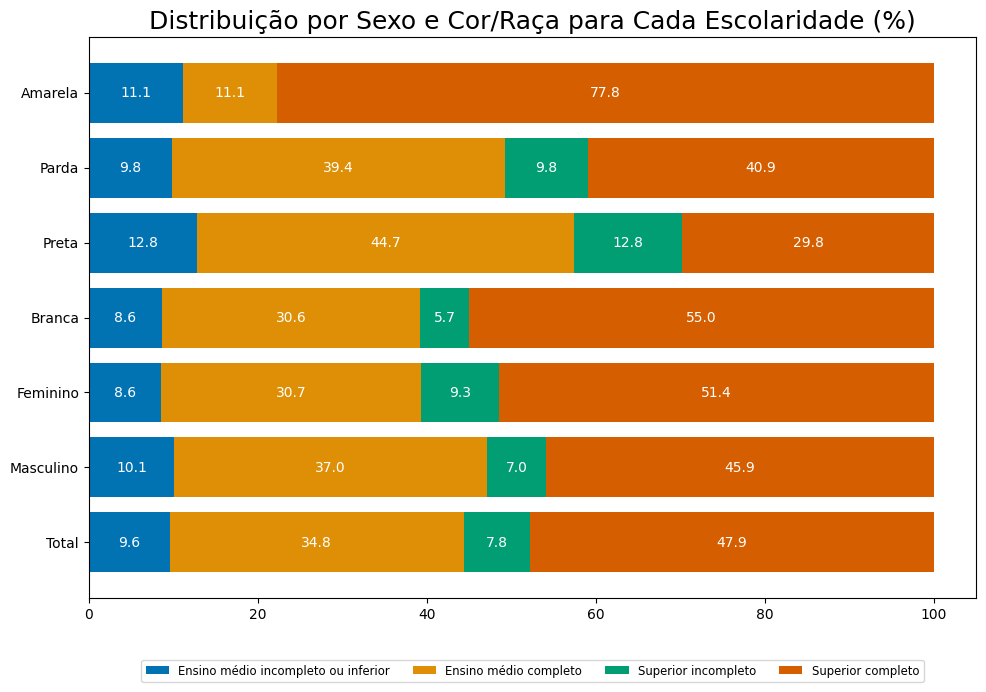

In [32]:
df = pd.DataFrame(df_barras_escolaridade)
categories = df['Escolaridade']
colors = sns.color_palette("colorblind", len(df)) # set de cores
min_value_for_text = 5 # limite percentual para exibição na barra(feature)

# criando o gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(10, 7))
bottom_values = [0] * len(df.columns[1:]) # eliminando primeira coluna


# Loop para criar as barras empilhadas
for i, escolaridade in enumerate(df['Escolaridade']):
    bars = ax.barh(
        df.columns[1:],
        df.loc[i, df.columns[1:]],
        left=bottom_values,
        label=escolaridade,
        color=colors[i % len(colors)])

    # adicionando valores dentro das barras (maiores que 5%)
    for bar, value in zip(bars, df.loc[i, df.columns[1:]]):
        if value > min_value_for_text:
            ax.annotate(
                f'{value:.1f}',  # Exibir o valor formatado
                xy=(bar.get_x() + bar.get_width()/2,
                    bar.get_y() + bar.get_height()/2),
                ha='center',
                va='center',
                color='white',
                fontsize=10,)

    # atualizando os valores "bottom" para empilhar
    bottom_values = [i + j for i, j in zip(bottom_values,
                                           df.loc[i, df.columns[1:]])]

# título e legendas
ax.set_title(
    'Distribuição por Sexo e Cor/Raça para Cada Escolaridade (%)', fontsize=18)
ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize='small')

plt.tight_layout()
plt.show()


Observamos que o ensino superior é predominante em todos os grupos, o que sugere que a maioria dos candidatos possui uma boa preparação acadêmica para assumir um cargo público. Em relação aos gêneros, o feminino apresenta uma taxa um pouco maior de ensino superior completo em comparação ao masculino, o que pode indicar que mulheres talvez enfrentem diferentes **exigências educacionais** para progredir na política.

Quando analisamos por cor/raça, alguns insights significativos podem ser observados. O mais marcante é o percentual de 77% de candidatos da cor/raça amarela com ensino superior completo, embora seja importante lembrar que eles representam apenas 3% dos candidatos. Outro dado relevante é o percentual de ensino superior completo entre as pessoas das cores/raças preta e parda, 29% e 40%, respectivamente, que são os menores entre os diversos grupos. No entanto, esses mesmos grupos são os que mais possuem ensino médio completo, o que pode sugerir a existência de **barreiras no acesso à educação superior** para essas populações.

### Ocupação

A ocupação de um candidato pode revelar muito sobre suas prioridades e áreas de atuação caso seja eleito, já que muitos tendem a defender causas ligadas às suas experiências profissionais. Profissões frequentemente influenciam a visão de mundo e o foco político dos candidatos, o que torna relevante entender suas trajetórias profissionais. Com isso em mente, vamos analisar as principais ocupações dos candidatos, buscando identificar padrões ou a predominância de determinadas áreas, o que pode nos ajudar a prever tendências políticas e temas prioritários em suas campanhas.

In [33]:
%%sql
CREATE TABLE IF NOT EXISTS lista_ocupacao AS
SELECT DS_OCUPACAO AS 'Ocupação',
COUNT (*) AS Quantidade
FROM candidatos_mogi
GROUP BY
DS_OCUPACAO
ORDER BY
quantidade desc
LIMIT 20;

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

In [34]:
df_lista_ocupacao = pd.read_sql('SELECT * FROM lista_ocupacao', engine)
df_lista_ocupacao

,Ocupação,Quantidade
0,OUTROS,66
1,EMPRESÁRIO,39
2,COMERCIANTE,26
3,SERVIDOR PÚBLICO MUNICIPAL,24
4,ADVOGADO,24
5,APOSENTADO (EXCETO SERVIDOR PÚBLICO),20
6,VEREADOR,19
7,VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,12
8,ADMINISTRADOR,11
9,DONA DE CASA,8


Text(0.5, 1.0, 'Top 20 profissões mais comuns entre os candidatos')

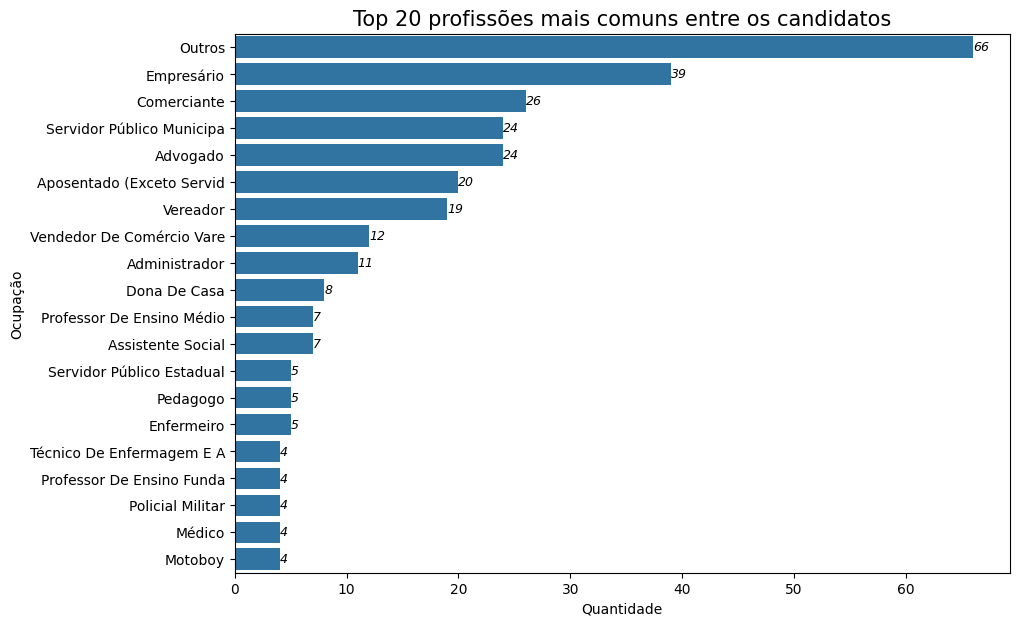

In [35]:
# criando o gráfico com o top 20 número de imóveis
# limitando a 25 caracteres e capitalizando primeira letra
df_lista_ocupacao['Ocupação'] = (df_lista_ocupacao
 ['Ocupação'].apply(lambda x: x[:25]).str.title())

top_bairros = df_lista_ocupacao

plt.figure(figsize=(10, 7))
sns.barplot(
    x = df_lista_ocupacao['Quantidade'],
    y = df_lista_ocupacao['Ocupação'],
    data = df_lista_ocupacao,
    orient = 'h'

)
for i in range(len(df_lista_ocupacao)):
    plt.text(
        df_lista_ocupacao['Quantidade'].values[i],
        i,
        f'{df_lista_ocupacao["Quantidade"].values[i]:.0f}',
        ha='left',
        va='center',
        fontsize=9,
        fontdict={'fontstyle':'italic'}
    )

plt.title('Top 20 profissões mais comuns entre os candidatos', fontsize=15)

Percebemos que muitos candidatos não informam sua ocupação, mas entre aqueles que o fazem, empresários, comerciantes, servidores públicos e advogados são os grupos mais frequentes. Isso provavelmente se deve à natureza de seus trabalhos, que estão fortemente relacionadas à **política e à gestão pública**. Logo em seguida, encontramos um número significativo de aposentados e vereadores buscando a reeleição. Esse grupo mostra que há uma tendência de continuidade, com candidatos que já possuem **experiência** política ou administrativa querendo manter sua presença no cenário político, o que pode indicar uma estratégia para capitalizar em sua experiência acumulada e fortalecer suas bases eleitorais.

## Perfil dos Partidos

Nesse perfil de análise iremos explorar como os candidatos estão distribuídos nos mais diversos partidos, usando de variáveis como SG_PARTIDO (partido), CD_GENERO (gênero), CD_GRAU_INSTRUCAO (escolaridade), CD_OCUPACAO (profissão) e CD_COR_RACA (cor/raça). Aqui focaremos mais na composição dos candidatos de cada partido, para traçar como o partido forma a escolha dos seus vereadores. Com o estudo dos dados vamos responder algumas perguntas:
- Quais partidos tem mais e menos candidatos?;
- Qual o percentual de mulheres e negros em cada partido?

**Palavras-chave**: especialização dos partidos, fortaleza dos partidos, inclusão e representatividade.

In [36]:
%%sql
SELECT SG_PARTIDO, COUNT(*) AS Total
FROM candidatos_mogi
GROUP BY NR_PARTIDO, SG_PARTIDO
ORDER BY Total DESC;

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


SG_PARTIDO,Total
PODE,26
PL,25
UNIÃO,25
PSD,25
REPUBLICANOS,24
PP,24
PDT,24
MDB,24
PRD,24
PRTB,24


In [37]:
df_total_partido = pd.read_sql(
    'SELECT SG_PARTIDO, COUNT(*) AS total_candidatos FROM candidatos_mogi GROUP BY NR_PARTIDO, SG_PARTIDO ORDER BY total_candidatos DESC;', engine)

In [38]:
df_total_partido.style.background_gradient(cmap='Blues', subset='total_candidatos')

,SG_PARTIDO,total_candidatos
0,PODE,26
1,PL,25
2,UNIÃO,25
3,PSD,25
4,REPUBLICANOS,24
5,PP,24
6,PDT,24
7,MDB,24
8,PRD,24
9,PRTB,24


In [39]:
%%sql
CREATE TABLE IF NOT EXISTS colormap_candidatos AS
SELECT
    SG_PARTIDO,
    COUNT(*) AS Total,
    --- calculando idade média
    ROUND(AVG(CAST((julianday('now') - julianday(
        substr(DT_NASCIMENTO, 7, 4) || '-' ||
        substr(DT_NASCIMENTO, 4, 2) || '-' ||
        substr(DT_NASCIMENTO, 1, 2))) / 365.25 AS INTEGER)), 0) AS 'Idade Média',
    --- calculando o percentual de gênero
    ROUND(CAST(SUM(
      CASE WHEN CD_GENERO = 2 THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0)
      AS DECIMAL(10,4)), 2) AS '%_Masculino',
    ROUND(CAST(SUM(
      CASE WHEN CD_GENERO = 4 THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0)
      AS DECIMAL(10,4)), 2) AS '%_Feminino',
    --- calculando os percentuais de cor/raça
    ROUND(CAST(SUM(
      CASE WHEN CD_COR_RACA = 1 THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0)
      AS DECIMAL(10,4)), 2) AS 'Branca',
    ROUND(CAST(SUM(
      CASE WHEN CD_COR_RACA = 2 THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0)
      AS DECIMAL(10,4)), 2) AS 'Preta',
    ROUND(CAST(SUM(
      CASE WHEN CD_COR_RACA = 3 THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0)
      AS DECIMAL(10,4)), 2) AS 'Parda',
    ROUND(CAST(SUM(
      CASE WHEN CD_COR_RACA = 4 THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0)
      AS DECIMAL(10,4)), 2) AS 'Amarela',
    --- calculando a moda da escolaridade (subquerry e inner p/integridade)
    (SELECT CD_GRAU_INSTRUCAO
     FROM candidatos_mogi AS inner_table
     WHERE inner_table.SG_PARTIDO = candidatos_mogi.SG_PARTIDO
     GROUP BY CD_GRAU_INSTRUCAO
     ORDER BY COUNT(*) DESC
     LIMIT 1) AS 'Escolaridade'
FROM
    candidatos_mogi
GROUP BY
    SG_PARTIDO
ORDER BY
    Total DESC;

   sqlite:///:memory:
 * sqlite:///eleicoes_sp.db
Done.


[]

In [40]:
df_colormap_candidatos = pd.read_sql('SELECT * FROM colormap_candidatos', engine)
df_colormap_candidatos

,SG_PARTIDO,Total,Idade Média,%_Masculino,%_Feminino,Branca,Preta,Parda,Amarela,Escolaridade
0,PODE,26,51.0,65.38,34.62,50.00,3.85,34.62,11.54,8
1,UNIÃO,25,49.0,68.00,32.00,76.00,4.00,16.00,4.00,8
2,PSD,25,53.0,64.00,36.00,72.00,4.00,24.00,0.00,8
3,PL,25,49.0,60.00,40.00,60.00,0.00,28.00,12.00,8
4,SOLIDARIEDADE,24,46.0,66.67,33.33,0.00,25.00,75.00,0.00,6
5,REPUBLICANOS,24,50.0,66.67,33.33,62.50,0.00,37.50,0.00,6
6,PSB,24,49.0,66.67,33.33,41.67,16.67,37.50,4.17,8
7,PRTB,24,43.0,62.50,37.50,62.50,4.17,29.17,4.17,6
8,PRD,24,46.0,66.67,33.33,62.50,8.33,29.17,0.00,8
9,PP,24,49.0,66.67,33.33,70.83,12.50,16.67,0.00,6


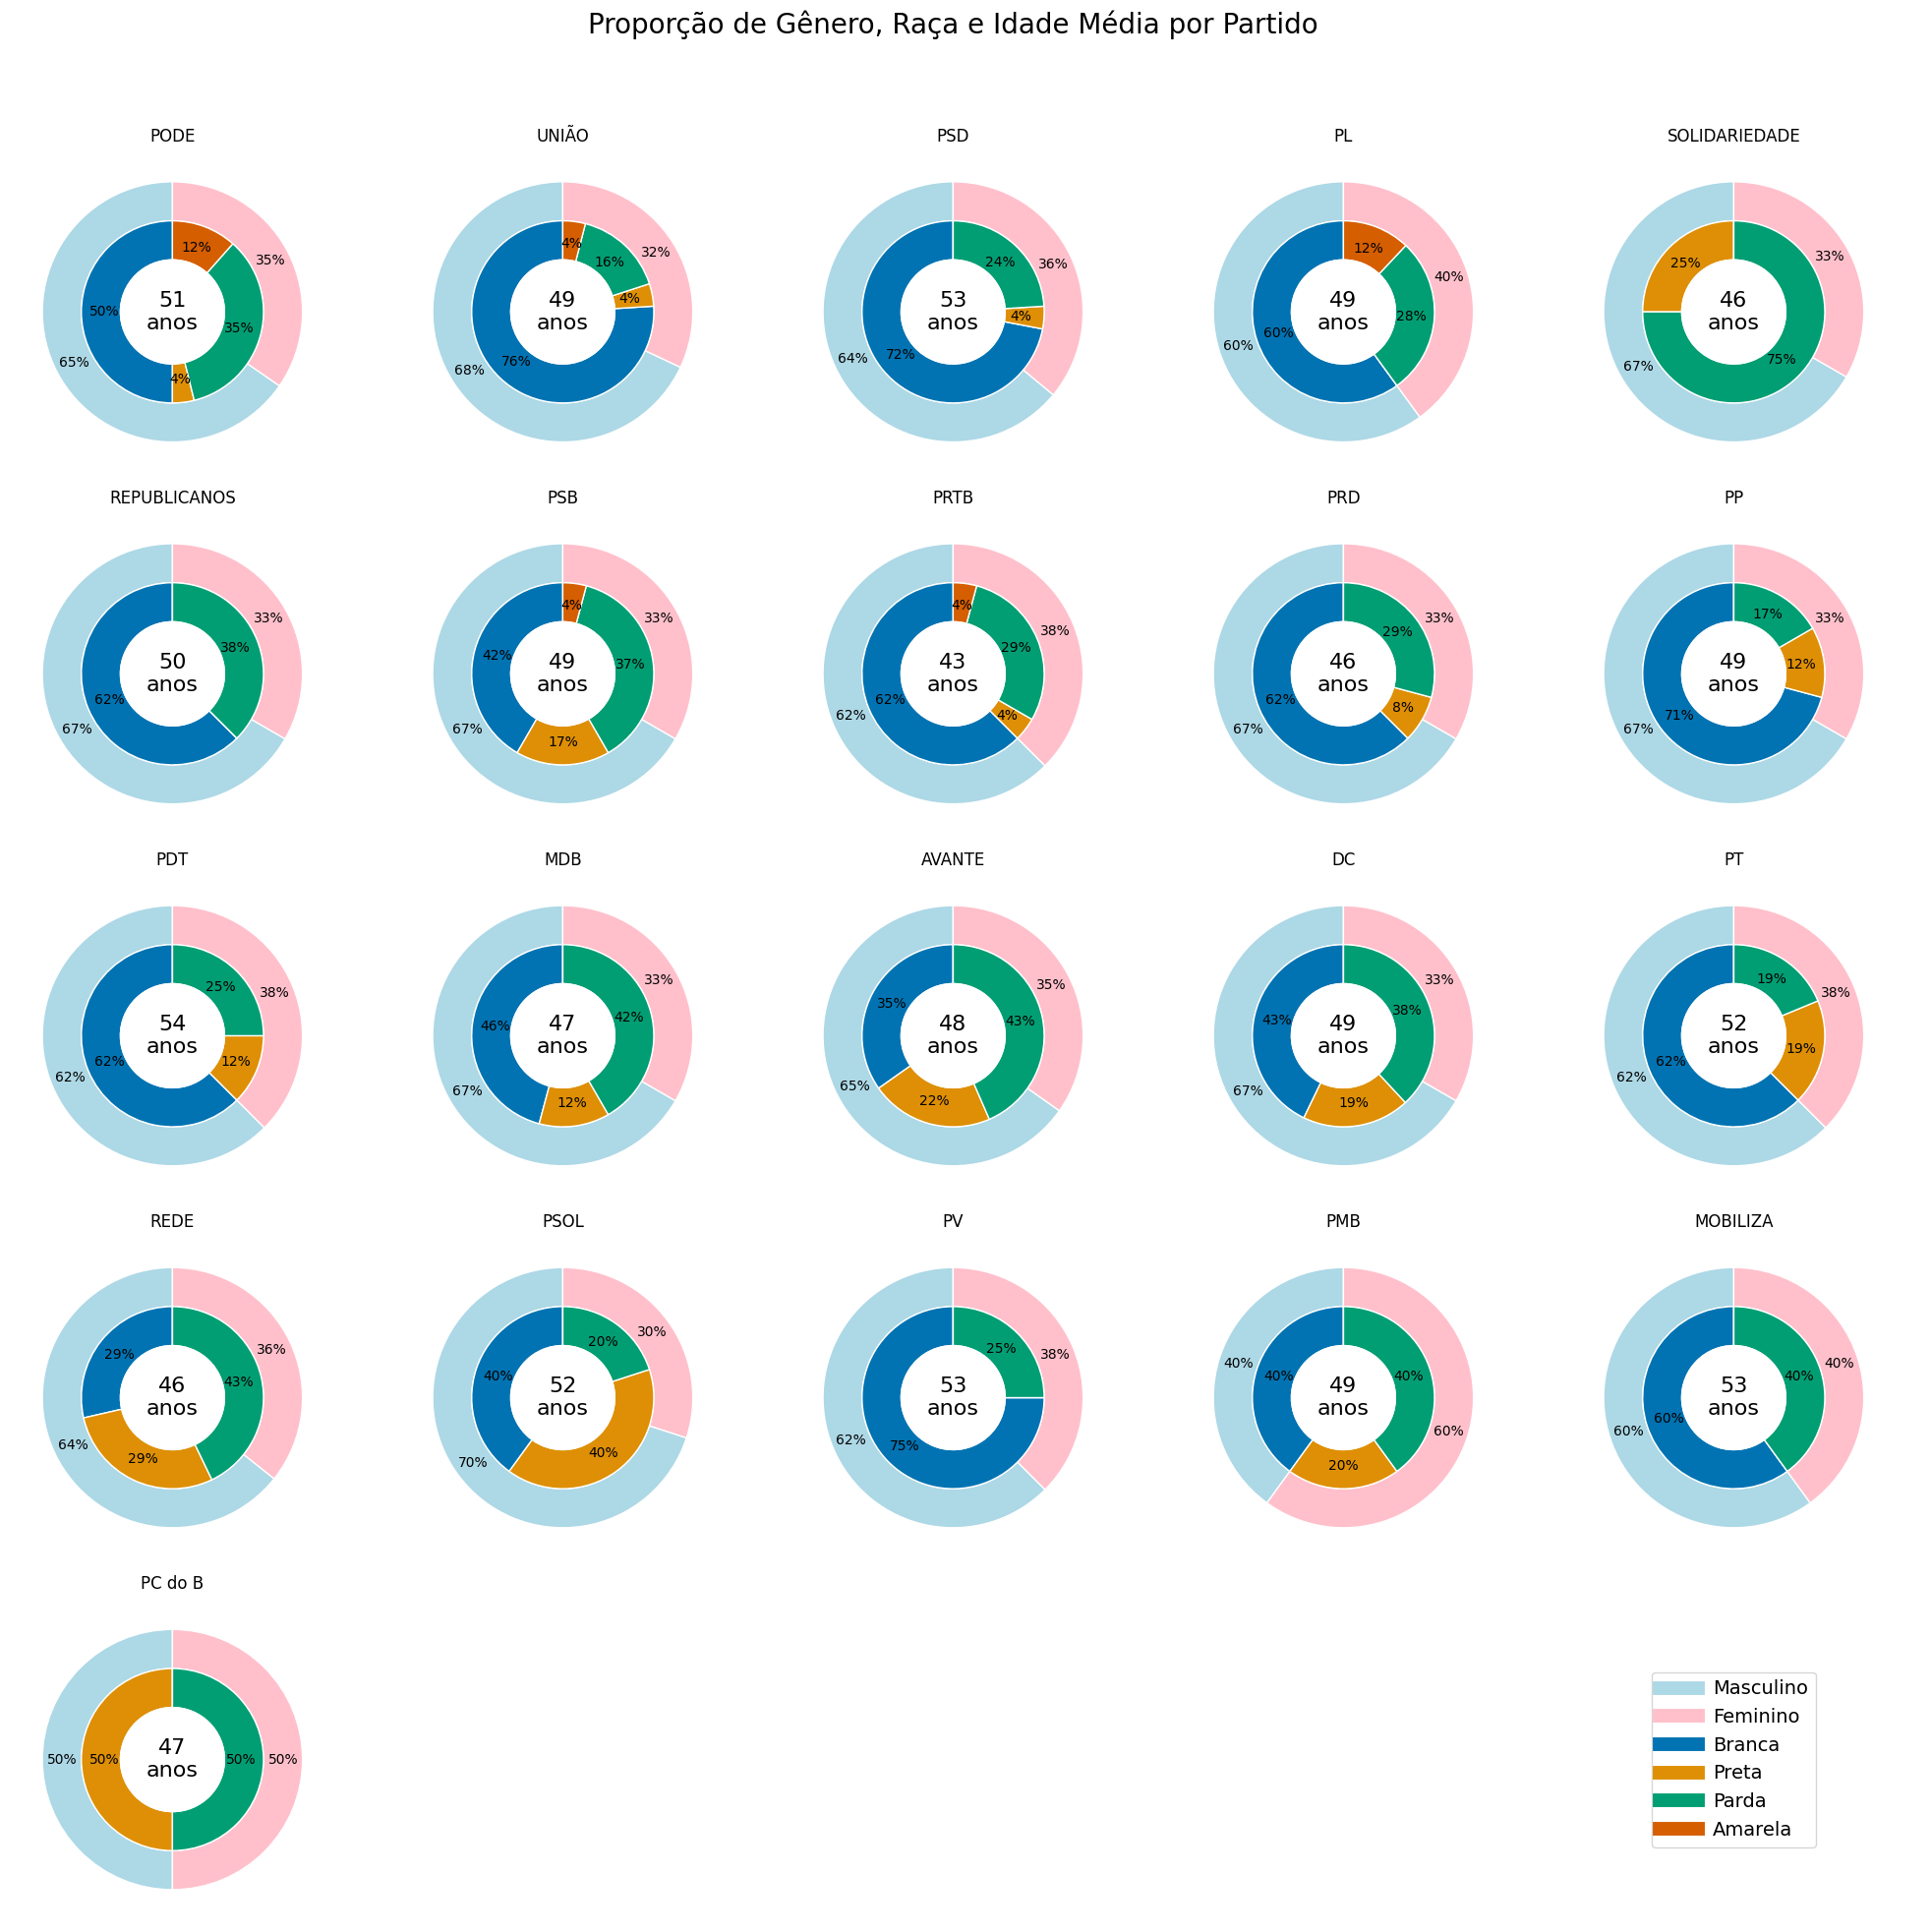

In [41]:
df = df_colormap_candidatos
colorblind_palette = sns.color_palette("colorblind", 4)

# função para limpar os valores (%) menos que 0
def autopct_format(values):
    def autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.0f}%' if val > 0 else ''
    return autopct

# definindo função para criar os gráficos
def plot_pizza_party(ax, partido, masculino, feminino,
                     branca, preta, parda, amarela, idade_media):
    sizes_gender = [masculino, feminino] # tamanho
    colors_gender = ['lightblue', 'pink'] #cor
    # configurando gráfico maior
    ax.pie(sizes_gender, radius=1, colors=colors_gender, startangle=90,
           wedgeprops=dict(width=0.3, edgecolor='w'),
           autopct=autopct_format(sizes_gender), pctdistance=0.85)
    sizes_race = [branca, preta, parda, amarela]
    colors_race = colorblind_palette
    # configurando gráfico menor
    ax.pie(sizes_race, radius=0.7, colors=colors_race, startangle=90,
           wedgeprops=dict(width=0.3, edgecolor='w'),
           autopct=autopct_format(sizes_race), pctdistance=0.75)
    # circulo branco central com dados
    ax.text(0, 0, f"{idade_media:.0f}\nanos",
            ha='center', va='center', fontsize=16, color='black')
    ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))
    # título de cada gráfico com nome de partido
    ax.set_title(partido, fontsize=12)

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# iterando sobre os partidos e criando gráfico
for i, (index, row) in enumerate(df.iterrows()):
    ax = axes[i // 5, i % 5]
    plot_pizza_party(ax,
                     row['SG_PARTIDO'],
                     row['%_Masculino'],
                     row['%_Feminino'],
                     row['Branca'],
                     row['Preta'],
                     row['Parda'],
                     row['Amarela'],
                     row['Idade Média'])

for j in range(i + 1, 24):
    fig.delaxes(axes.flatten()[j])

last_ax = axes.flatten()[-1]  # último espaço para legenda

# limpando o último gráfico e adicionando a legenda
last_ax.clear()
colors_gender = ['lightblue', 'pink']
gender_labels = ['Masculino', 'Feminino']
race_labels = ['Branca', 'Preta', 'Parda', 'Amarela']

last_ax.legend(
    handles=[plt.Line2D([0], [0], color=color,
                        lw=10) for color in colors_gender + colorblind_palette],
    labels=gender_labels + race_labels,
    loc='center',
    fontsize=14)
last_ax.set_axis_off()  # ocultando o eixo do gráfico

# título geral dos gráficos
fig.suptitle('Proporção de Gênero, Raça e Idade Média por Partido', fontsize=20)

# ajustando gráficos e legenda
plt.tight_layout(rect=[0, 0, 1, 0.95])  # espaço para o título
plt.show()


Agora vamos que temos a visualização de todos os partidos, vamos gerar os insights através de medidas estatísticas:

In [42]:
df = df_colormap_candidatos

# 1. partido com maior % masculino
print('Gênero')
partido_maior_masculino = df.loc[
    df['%_Masculino'].idxmax(), ['SG_PARTIDO', '%_Masculino']]
print(f"Partido com maior número de homens: {partido_maior_masculino['SG_PARTIDO']} com {partido_maior_masculino['%_Masculino']}% homens")

# 2. partido com maior % feminino
partido_maior_femino = df.loc[
    df['%_Feminino'].idxmax(), ['SG_PARTIDO', '%_Feminino']]
print(f"Partido com maior número de mulheres: {partido_maior_femino['SG_PARTIDO']} com {partido_maior_femino['%_Feminino']}% mulheres")

# função para analisar cor/raça
def analisar_cor_raca(cor):
    print(f'Cor/Raça: {cor.capitalize()}')
    partido_maior = df.loc[df[cor].idxmax(), ['SG_PARTIDO', cor]]

    # partidos com 0% da cor/raça
    partidos_sem_cor = df.loc[df[cor] == 0, ['SG_PARTIDO', cor]]

    print(f"Partido com maior número de cor/raça {cor}: {partido_maior['SG_PARTIDO']} com {partido_maior[cor]}% ")

    # verifica se existe algum partido com percentual maior que 0
    if partidos_sem_cor.empty:
        partido_menor = df.loc[
            df[cor] > 0].loc[df[cor].idxmin(), ['SG_PARTIDO', cor]]
        print(f"Partido com menor número de {cor}: {partido_menor['SG_PARTIDO']} com {partido_menor[cor]}% ")
    else:
        partidos_sem_cor_list = ', '.join(partidos_sem_cor['SG_PARTIDO'])
        print(f"Partidos sem nenhum representante da cor/raça {cor}: {partidos_sem_cor_list}")

# 3. Análise das raças
analisar_cor_raca('Branca')
analisar_cor_raca('Preta')
analisar_cor_raca('Parda')
analisar_cor_raca('Amarela')

# 4. partido com maior e menor idade média
print('Idade Média')
partido_maior_idade = df.loc[
    df['Idade Média'].idxmax(), ['SG_PARTIDO', 'Idade Média']]
partido_menor_idade = df.loc[
    df['Idade Média'].idxmin(), ['SG_PARTIDO', 'Idade Média']]
print(f"Partido com maior idade média: {partido_maior_idade['SG_PARTIDO']} com {partido_maior_idade['Idade Média']} anos")
print(f"Partido com menor idade média: {partido_menor_idade['SG_PARTIDO']} com {partido_menor_idade['Idade Média']} anos")


Gênero
Partido com maior número de homens: PSOL com 70.0% homens
Partido com maior número de mulheres: PMB com 60.0% mulheres
Cor/Raça: Branca
Partido com maior número de cor/raça Branca: UNIÃO com 76.0% 
Partidos sem nenhum representante da cor/raça Branca: SOLIDARIEDADE, PC do B
Cor/Raça: Preta
Partido com maior número de cor/raça Preta: PC do B com 50.0% 
Partidos sem nenhum representante da cor/raça Preta: PL, REPUBLICANOS, PV, MOBILIZA
Cor/Raça: Parda
Partido com maior número de cor/raça Parda: SOLIDARIEDADE com 75.0% 
Partido com menor número de Parda: UNIÃO com 16.0% 
Cor/Raça: Amarela
Partido com maior número de cor/raça Amarela: PL com 12.0% 
Partidos sem nenhum representante da cor/raça Amarela: PSD, SOLIDARIEDADE, REPUBLICANOS, PRD, PP, PDT, MDB, AVANTE, DC, PT, REDE, PSOL, PV, PMB, MOBILIZA, PC do B
Idade Média
Partido com maior idade média: PDT com 54.0 anos
Partido com menor idade média: PRTB com 43.0 anos


***Gênero***

 - Representação Masculina: O **PSOL se destaca como o partido com a maior proporção de homens, apresentando 70%** de seus membros masculinos. Essa alta representatividade masculina sugere uma predominância no apoio e na liderança masculina dentro da estrutura do partido.

 - Representação Feminina: **O PMB se sobressai com 60% de mulheres**, indicando um compromisso significativo com a inclusão feminina. Isso pode refletir políticas voltadas para a promoção de igualdade de gênero e empoderamento feminino dentro do partido.

***Cor/Raça***

- Raça Branca: **O partido UNIÃO possui a maior representatividade de indivíduos brancos, com 76% de seus membros**. Essa predominância indica uma possível falta de diversidade racial. Por outro lado, partidos como SOLIDARIEDADE e PC do B não têm representantes brancos, o que pode refletir uma abordagem inclusiva ou, alternativamente, uma falta de foco na representação racial.

- Raça Preta: **O PC do B lidera com 50% de representação preta**. Essa alta porcentagem sugere uma significativa inclusão de pessoas negras na política deste partido. Contudo, há uma preocupação, pois partidos como PL, REPUBLICANOS, PV, e MOBILIZA não apresentam nenhum representante da cor/race preta, evidenciando uma falta de diversidade racial.

- Raça Parda: **O partido SOLIDARIEDADE se destaca com 75%** de pardos, o que demonstra uma boa inclusão racial. No entanto, o UNIÃO apresenta apenas 16% de pardos, indicando uma disparidade significativa em comparação a outros partidos.

- Raça Amarela: **O partido PL é o único a ter um percentual de 12% de representantes amarelos**. A ausência de representantes amarelos em partidos como PSD, SOLIDARIEDADE, REPUBLICANOS, PRD, entre outros, sugere uma necessidade de maior inclusão racial.

***Idade Média***

- Idade Média dos Membros: **O PDT tem a maior média de idade entre seus membros, com 54 anos**. Isso pode indicar uma base de apoio mais envelhecida, o que pode influenciar as políticas e a abordagem do partido em relação a questões sociais. Em contraste, o **PRTB possui a menor média de idade, 43 anos**, o que pode sinalizar uma tentativa de atrair uma base mais jovem e progressista.

In [43]:
# conferir quantas tabelas foram criadas DO DB
metadata = MetaData()
metadata.reflect(bind=engine)
tabelas = metadata.tables.keys()
# Exibir o número de tabelas
print(f"Número de tabelas: {len(tabelas)}")

# Exibir os nomes das tabelas
print("Tabelas:", list(tabelas))

Número de tabelas: 8
Tabelas: ['barras_escolaridade', 'candidatos_mogi', 'colormap_candidatos', 'idades_canditos', 'lista_ocupacao', 'piramide_etaria', 'pizza_cor_raca', 'tabela_csv']


# Conclusão

A análise dos candidatos municipais de Mogi das Cruzes em 2024 proporcionou insights valiosos sobre o perfil dos candidatos, destacando a representatividade de gênero e raça no cenário político local. Observamos uma predominância de candidatos na faixa etária da meia-idade e uma alta taxa de escolaridade, com destaque para a participação significativa de candidatos de cor/raça parda e preta em relação à população. Embora alguns partidos demonstrem um compromisso com a inclusão, ainda existem disparidades que indicam a necessidade de um maior foco na diversidade.

- **Idade**: A maioria dos candidatos está na faixa de meia-idade, com uma média de aproximadamente 49 anos.
- **Gênero**: Foi identificado um desequilíbrio de gênero, com uma maior representatividade masculina entre os candidatos.
- **Cor/Raça**: A cor/raça branca possui a maior representatividade entre os candidatos, embora a representatividade dos candidatos pardos e pretos esteja acima da média.
- **Escolaridade**: A maioria dos candidatos possui ensino superior completo, indicando que o perfil educacional dos candidatos é elevado.
- **Ocupação**: As ocupações mais comuns incluem profissionais da educação, empresários e servidores públicos.

A utilização de Python, juntamente com bibliotecas de visualização e manipulação de dados, e o uso de SQL para facilitar a consulta e a criação das tabelas, possibilitaram uma análise aprofundada e eficaz dos dados coletados. Este projeto não só serve como uma base para futuras análises e discussões sobre a evolução da política em Mogi das Cruzes, mas também como um incentivo para ações que promovam uma representação mais equitativa e diversificada nas próximas eleições.

## Sugestões e Melhorias

Ao decorrer do projeto diversas dideiam foram surgindo, as que mais se encaixavam no escopo do projeto foram agragada à ele. Porém diversas outras ideias e melhoria foram encontradas porém divergiam um pouco do objetivo do projeto, as principais que foram observadas foram:
- Aprimoração da visualização com opções avançadas como mapas de calor e gráficos interativos;
- Analise temporal, comparando diversos outros anos de eleições ou futuramente revisitando esse projeto para novas eleições;
- Ampliação do escopo, foi uma das mais presentes durante o projeto além das informações demográficas podemos incluir novas como financeiras do candidato, gasto eleitoral, propostas de candidatos e partidos. Tais análises enriqueceriam muito os insights encontrados.



Sinta-se à vontade para contribuir com este projeto me enviando sugestões ou mensagens. Toda ajuda para melhorar as análises ou adicionar novos insights será bem-vinda.

Douglas Rizzi Gomes

[LinkedIn](https://www.linkedin.com/in/douglas-rizzi/)

[E-mail](mailto:douglasrizzi10@gmail.com)